In [1]:
#|default_exp train

In [2]:
# !pip install -U transformers nbdev fastcore accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [4]:
#|export
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
from types import SimpleNamespace
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from utils import (
    plot_density, 
    pil_add_text, 
    latent_to_PIL, 
    make_grid, 
    fmnist_labels, 
    encode_prompt, 
    dcae_scalingf, 
    pil_clipscore, 
    free_memory, 
    get_rnd_sigmas,
    linear_multistep_coeff,
    get_sigma_schedule,
)

seed = 42
set_seed(seed)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
#|export
def load_models(text_encoder, transformer_config, ae, dtype, device):
    transformer = SanaTransformer2DModel.from_config(transformer_config).to(device).to(dtype)
    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

# source: https://github.com/crowsonkb/k-diffusion/blob/8018de0b43da8d66617f3ef10d3f2a41c1d78836/k_diffusion/sampling.py#L261
def generate_lms(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, order=2, latent_seed=None):
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dtype).to(device)
    sigmas, timesteps = get_sigma_schedule(num_steps)
    ds = []
    for i in range(len(sigmas) - 1):
        t = timesteps[None, i].to(device)
        with torch.no_grad():
            noise_pred = transformer(
                latent, 
                timestep=t, 
                encoder_hidden_states=prompt_encoded, 
                encoder_attention_mask=prompt_atnmask, 
                return_dict=False
            )[0]
        ds.append(noise_pred)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i + 1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigmas, i, j) for j in range(cur_order)]
        latent = latent + sum(coeff * d for coeff, d in zip(coeffs, reversed(ds)))
    return latent_to_PIL(latent / dcae_scalingf, dcae)

def generate(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, latent_seed=None):
    assert latent_dim is not None
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dtype).to(device)
    sigmas, timesteps = get_sigma_schedule(num_steps)

    for t, sigma_prev, sigma_next in zip(timesteps, sigmas[:-1], sigmas[1:]):
        t = t[None].to(latent.dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(
                latent, 
                timestep=t, 
                encoder_hidden_states=prompt_encoded, 
                encoder_attention_mask=prompt_atnmask, 
                return_dict=False
            )[0]
        latent = latent + (sigma_next - sigma_prev) * noise_pred 

    return latent_to_PIL(latent / dcae_scalingf, dcae)

def add_random_noise(latents, dist, timesteps=1000):
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    sigmas = get_rnd_sigmas(bs, dist=dist).to(latents.device)  # floats 0-1 of dist specified in train_config
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, `timesteps = sigmas * 1000`, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), noise, timesteps

def eval_loss(dataloader_eval, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist=train_config.sigma_sampling)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
    return sum(losses)/len(losses)

In [6]:
#|export
dtype = torch.bfloat16
device = "cuda" 
debug = True
ddp = True

model_config = SimpleNamespace(
    text_encoder = "answerdotai/ModernBERT-large",
    transformer_config = "transformer_Sana-DiT-B-MBERT-large.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
)

data_config = SimpleNamespace(
    dataset = "g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0",
    col_label = "label",
    col_latent = "latent",
    split_train = "train",
    split_eval = "test",
    latent_shape = [1, 32, 3, 3]
)

train_config = SimpleNamespace(
    lr = 5e-4,
    bs = 1024,
    epochs = 500,
    steps_log = 10,
    steps_eval = 300,
    eval_prompts = [
        "a collection of comic books on a table",
        "a green plant with a green stem",
        "an airplane in the sky",
        "two fighter jets on the red sky",
        "a blonde girl",
        "a red car",
        "a blue car",
    ],
    eval_seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    eval_timesteps = 100, # number of timesteps for generating eval images
    timesteps_training = 1000,
    sigma_sampling = "normal",  # beta uniform normal
    log_wandb = True,
    wandb_project = "Hana",
    wandb_run = "Sana-DiT-B-{size:.2f}M_{ds}_LR-{lr}_BS-{bs}_{ts_sampling}-TS-{ts}_{ws}x{device}",
)

In [7]:
#|export

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class ImageNet96Dataset(torch.utils.data.Dataset):
    def __init__(self, hf_ds, text_enc, tokenizer, bs, ddp, col_label="label", col_latent="latent"):
        self.hf_ds=hf_ds
        self.col_label, self.col_latent = col_label, col_latent
        self.text_enc, self.tokenizer =  text_enc, tokenizer
        self.tokenizer.padding_side = "right"
        self.prompt_len = 50
        
        if ddp: 
            self.sampler = DistributedSampler(hf_ds, shuffle = True, seed = seed)
        else: 
            self.sampler = RandomSampler(hf_ds, generator = torch.manual_seed(seed))
        self.dataloader = DataLoader(
            hf_ds, sampler=self.sampler, collate_fn=self.collate, batch_size=bs, num_workers=4, prefetch_factor=2
        )

    def collate(self, items):
        labels = [i[self.col_label] for i in items]
        # [B, 32, 3, 3]
        latents = torch.Tensor([i[self.col_latent] for i in items]).squeeze()
        # # pick random augmentation -> [B, num_aug, 32, 3, 2]
        # latents = latents[:, random.randint(0,3)].to(dtype)
        
        return labels, latents
        
    def __iter__(self):
        for labels, latents in self.dataloader:
            label_embs, label_atnmasks = self.encode_prompts(labels)
            latents = latents.to(dtype).to(device)
            yield labels, latents, label_embs, label_atnmasks
    
    def encode_prompts(self, prompts):
        prompts_tok = self.tokenizer(
            prompts, padding="max_length", truncation=True, max_length=self.prompt_len, return_tensors="pt"
        )
        with torch.no_grad():
            prompts_encoded = self.text_enc(**prompts_tok.to(self.text_enc.device))
        return prompts_encoded.last_hidden_state, prompts_tok.attention_mask

    def __len__(self):
        return len(self.dataloader)

In [8]:
# DON'T EXPORT
ddp = False

In [9]:
#|export
if ddp:
    dist.init_process_group(backend='nccl')
    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    debug = debug and is_master
else:
    # Running on single GPU or in notebook
    is_master = True
    world_size = 1
    local_rank = 0

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = model_config.text_encoder,
    transformer_config = model_config.transformer_config,
    ae = model_config.ae,
    dtype = dtype,
    device = device
)
if ddp:
	transformer = DistributedDataParallel(transformer, device_ids=[local_rank])
    
ds = load_dataset(data_config.dataset)

dataloader_train = ImageNet96Dataset(
    ds[data_config.split_train], text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=ddp
)
dataloader_eval = ImageNet96Dataset(
    ds[data_config.split_eval], text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=ddp
)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=train_config.lr)

wandb_run = train_config.wandb_run.format(
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    ts=train_config.timesteps_training,
    ts_sampling=train_config.sigma_sampling.upper(),
    device=device,
    ds=data_config.dataset.split("/")[1].split("-")[0],
    ws=world_size,
)

steps_epoch = len(dataloader_train)
if is_master: 
    print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Transformer parameters: 116.08M
DCAE parameters: 312.25M
steps per epoch: 1252


W0222 14:34:56.848000 134757683824192 torch/_inductor/compile_worker/subproc_pool.py:126] SubprocPool unclean exit


Sigma distribution:


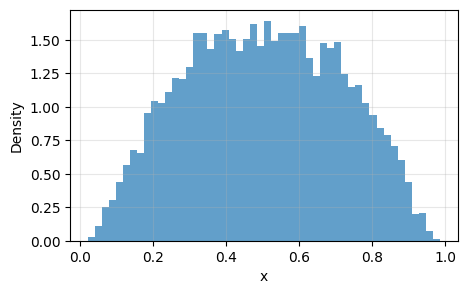

Testing noising:


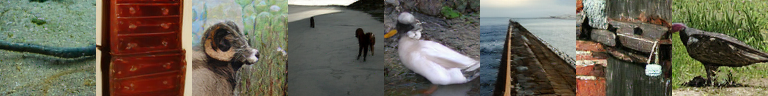

timesteps rounded [190, 869, 303, 578, 408, 312, 317, 150]


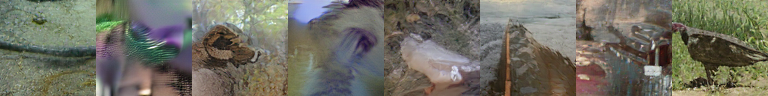

Eval prompts:
[(0, 'a collection of comic books on a table'), (1, 'a green plant with a green stem'), (2, 'an airplane in the sky'), (3, 'two fighter jets on the red sky'), (4, 'a blonde girl'), (5, 'a red car'), (6, 'a blue car')]
Inspecting first batch


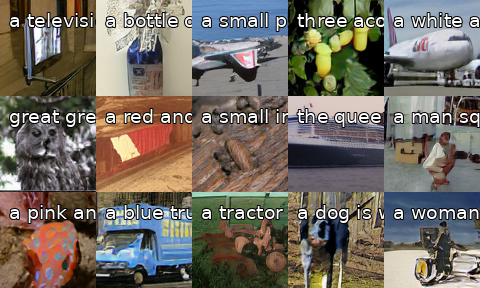

Testing generate


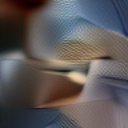

Testing eval loss


eval_loss: 0it [00:03, ?it/s]


2.34375
Testing eval images and clip score


eval_images: 100%|██████████████████████████████████████████| 7/7 [00:03<00:00,  2.24it/s]


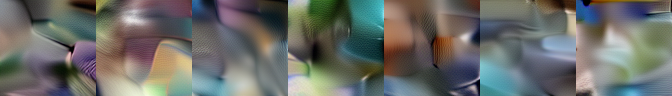

20.979324340820312


In [10]:
# DONT EXPORT
if is_master: 
    print("Sigma distribution:")
    sigmas = get_rnd_sigmas(10_000, train_config.sigma_sampling)
    plot_density(sigmas)

    print("Testing noising:")
    def test_noising():
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
        # latents=latents.to(dtype).to(device)
        latent=latents[0:8,:] * dcae_scalingf
        display(make_grid(latent_to_PIL(latent / dcae_scalingf,dcae)))
        
        latent_noisy, noise, timesteps = add_random_noise(latent, dist=train_config.sigma_sampling)
        
        print("timesteps rounded", list(map(round, timesteps.tolist())))
        display(make_grid(latent_to_PIL(latent_noisy / dcae_scalingf,dcae)))
    test_noising()

    print("Eval prompts:")
    print(list(enumerate(train_config.eval_prompts)))
    
    print("Inspecting first batch")
    def show_first_batch(dataloader):
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
        # latents=latents.to(dtype).to(device)
        images = [pil_add_text(latent_to_PIL(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
        display(make_grid(images[:15], 3, 5))
    show_first_batch(dataloader_train)
    
    print("Testing generate")
    display(generate("horse", tokenizer, text_encoder, num_steps=10, latent_dim=data_config.latent_shape).resize((128,128)))
    
    print("Testing eval loss")
    print(eval_loss(dataloader_eval, testing=True))
    
    print("Testing eval images and clip score")
    images = [
        generate(p, tokenizer, text_encoder, latent_dim=data_config.latent_shape, num_steps=10) 
        for p in tqdm(train_config.eval_prompts, "eval_images")
    ]
    display(make_grid(images))
    print(pil_clipscore(images, train_config.eval_prompts))

# Train

In [11]:
import nbdev; nbdev.export.nb_export(__session__)

In [12]:
#|export

free_memory()

if is_master and train_config.log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(
        project=train_config.wandb_project, 
        name=wandb_run
    ).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()
free_memory()

for epoch in range(train_config.epochs):
    if ddp: dataloader_train.sampler.set_epoch(epoch)
    
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader_train:
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist = train_config.sigma_sampling)
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(noise_pred, noise - latents)
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if is_master and step>0 and step % train_config.steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
            sample_count = step * train_config.bs * world_size
            sample_tp = train_config.bs * train_config.steps_log * world_size / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.2f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if train_config.log_wandb: 
                wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": sample_count, "epoch": step / steps_epoch})
            last_step_time = time.time()

        if is_master and step>0 and step % train_config.steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)

            # try different seeds for generating eval images
            images_eval = [
                generate_lms(p, tokenizer, text_encoder, num_steps=train_config.eval_timesteps, latent_dim=data_config.latent_shape, latent_seed=seed) 
                for seed in tqdm(train_config.eval_seeds, "eval_images")
                for p in train_config.eval_prompts
            ]
            clipscore = pil_clipscore(images_eval, train_config.eval_prompts * len(train_config.eval_seeds))
            # add labels before logging the images
            images_eval = make_grid([
                pil_add_text(img, train_config.eval_prompts[i % len(train_config.eval_prompts)]) 
                for i, img in enumerate(images_eval)
            ], rows=len(train_config.eval_seeds), cols=len(train_config.eval_prompts))
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if train_config.log_wandb: 
                wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": step * train_config.bs, "epoch": step / steps_epoch})
            transformer.train()        

        step += 1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 10, epoch: 0.01, train loss: 1.8906, grad_norm: 2.30, 1057.03ms/step, 968.76samples/sec
step 20, epoch: 0.02, train loss: 1.8516, grad_norm: 1.05, 589.44ms/step, 1737.23samples/sec
step 30, epoch: 0.02, train loss: 1.8047, grad_norm: 0.51, 596.86ms/step, 1715.65samples/sec
step 40, epoch: 0.03, train loss: 1.7891, grad_norm: 0.46, 585.14ms/step, 1750.00samples/sec
step 50, epoch: 0.04, train loss: 1.7656, grad_norm: 0.49, 592.56ms/step, 1728.10samples/sec
step 60, epoch: 0.05, train loss: 1.7422, grad_norm: 0.56, 588.80ms/step, 1738.95samples/sec
step 70, epoch: 0.06, train loss: 1.7031, grad_norm: 0.45, 590.19ms/step, 1735.03samples/sec
step 80, epoch: 0.06, train loss: 1.6719, grad_norm: 0.64, 585.10ms/step, 1750.14samples/sec
step 90, epoch: 0.07, train loss: 1.6250, grad_norm: 0.97, 695.30ms/step, 1472.75samples/sec
step 100, epoch: 0.08, train loss: 1.5781, grad_norm: 0.77, 583.85ms/step, 1753.88samples/sec
step 110, epoch: 0.09, train loss: 1.5312, grad_norm: 0.86, 586.53ms/

eval_loss: 49it [00:22,  2.20it/s]
eval_images: 100%|██████████████████████████████████████████| 5/5 [02:15<00:00, 27.01s/it]


step 300, eval loss: 1.3712, clipscore: 21.73
step 310, epoch: 0.25, train loss: 1.3594, grad_norm: 0.40, 17403.98ms/step, 58.84samples/sec
step 320, epoch: 0.26, train loss: 1.3594, grad_norm: 0.52, 749.80ms/step, 1365.70samples/sec
step 330, epoch: 0.26, train loss: 1.3594, grad_norm: 0.42, 596.39ms/step, 1717.00samples/sec
step 340, epoch: 0.27, train loss: 1.3594, grad_norm: 0.44, 601.01ms/step, 1703.81samples/sec
step 350, epoch: 0.28, train loss: 1.3516, grad_norm: 0.30, 599.92ms/step, 1706.88samples/sec
step 360, epoch: 0.29, train loss: 1.3594, grad_norm: 0.44, 593.11ms/step, 1725.55samples/sec
step 370, epoch: 0.30, train loss: 1.3672, grad_norm: 0.52, 594.75ms/step, 1721.74samples/sec
step 380, epoch: 0.30, train loss: 1.3672, grad_norm: 0.47, 592.04ms/step, 1729.60samples/sec
step 390, epoch: 0.31, train loss: 1.3516, grad_norm: 0.43, 592.32ms/step, 1728.79samples/sec
step 400, epoch: 0.32, train loss: 1.3438, grad_norm: 0.40, 682.15ms/step, 1501.12samples/sec


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a91a1cb7820>>
Traceback (most recent call last):
  File "/home/g/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a91a1cb7820>>
Traceback (most recent call last):
  File "/home/g/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
#|export
if ddp: torch.distributed.barrier()

if is_master:
    wandb.finish()
    transformer.module.push_to_hub(f"g-ronimo/hana-alpha27")

if ddp: dist.destroy_process_group()